In [82]:
import numpy as np 
import tensorflow as tf



In [84]:
from sklearn.model_selection import train_test_split

# Loading gFashion MNIST dataset
fashion_mnst = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnst

# splitting the dataset with stratified sampling
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                      test_size=0.1, 
                                                      stratify=y_train_full, 
                                                      random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (54000, 28, 28)
y_train shape: (54000,)
X_valid shape: (6000, 28, 28)
y_valid shape: (6000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [85]:
#Unique classes in the image 
num_unique_classes = len(np.unique(np.concatenate((y_train_full, y_valid))))
print("Number of unique classes:", num_unique_classes)

Number of unique classes: 10


In [86]:
X_train.dtype

dtype('uint8')

unsigned integer 8 bit 

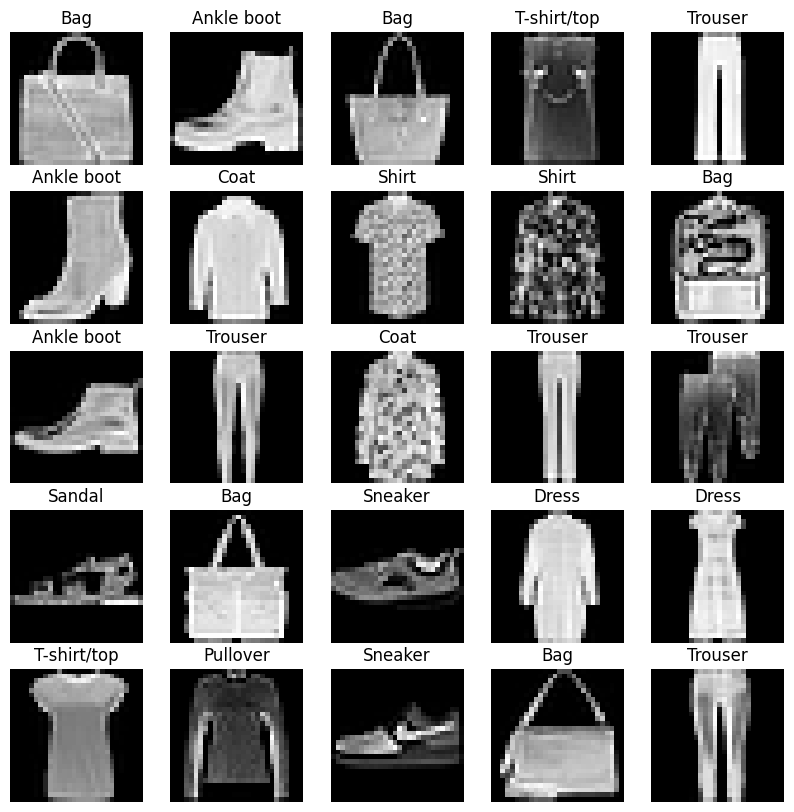

In [87]:
### exploring some images 

import matplotlib.pyplot as plt
#class label for 10 unique class
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize= (10, 10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.imshow(X_train[i], cmap = 'gray')
    plt.title(class_labels[y_train[i]])
    plt.axis('off')
plt.show()

In [88]:
class_labels[y_train[0]]

'Bag'

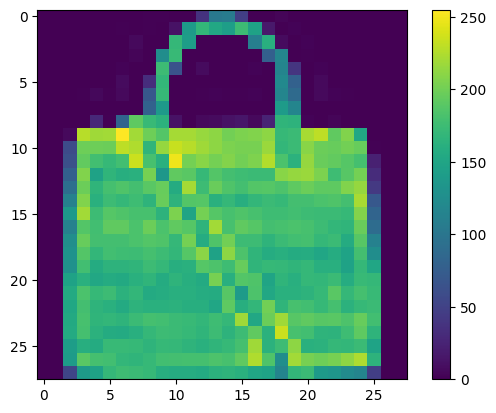

In [89]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()
plt.gca().grid(False)

we need to scale the value to a range of 0 to 1 before we feed the values to the neural network model.For this, cast datatype of the image components will be divided by 255.

### data preprocessing

In [90]:

X_train, X_valid, X_test = X_train/255. , X_valid/255. , X_test/255.



### Build a model

In [92]:
import keras_tuner as kt
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    # hyperparameters
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons_1 = hp.Int("n_neurons_1", min_value=16, max_value=256)
    n_neurons_2 = hp.Int("n_neurons_2", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling='log')  #sampling="log", learning rates of all scales will be sampled equally.
    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    # optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5, default=0.2)  # Specify dropout rate
    # Add hidden layers based on hyperparameters
    for i in range(n_hidden):
        model.add(tf.keras.layers.Dense(units=n_neurons_1 if i == 0 else n_neurons_2, activation=hp_activation))
        model.add(tf.keras.layers.Dropout(dropout_rate))  # Add dropout layer after each hidden layer

    # Output layer
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    #compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, weight_decay = 1e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model



In [93]:
# Instanting the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='keras_tuner_dir',
                     project_name='fashion_mnist_tuning')
#early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

# Perform the hyperparameter search
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_valid, y_valid), callbacks = [stop_early])

#   best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best number of hidden layers:", best_hps.get("n_hidden"))
print("Best number of neurons per layer:", best_hps.get("n_neurons_1"))
# print("Best learning rate:", best_hps.get("learning_rate"))
print("Best activation function:", best_hps.get("activation"))
print("Best optimizer:", best_hps.get("optimizer"))
print("Best dropout rate:", best_hps.get("dropout_rate"))

Reloading Tuner from keras_tuner_dir/fashion_mnist_tuning/tuner0.json
Best number of hidden layers: 2
Best number of neurons per layer: 231
Best activation function: relu
Best optimizer: sgd
Best dropout rate: 0.18123344927704288


In [94]:
# Build the final model with the best hyperparameters
best_model = build_model(best_hps)

# Train the model using the full training dataset
history = best_model.fit(X_train, y_train,
                         epochs=20, 
                         validation_data=(X_valid, y_valid),
                        #  batch_size = 32,
                         callbacks=[stop_early])  


Epoch 1/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5564 - accuracy: 0.8033 - val_loss: 0.3894 - val_accuracy: 0.8590
Epoch 2/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3976 - accuracy: 0.8556 - val_loss: 0.3519 - val_accuracy: 0.8738
Epoch 3/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3576 - accuracy: 0.8703 - val_loss: 0.3237 - val_accuracy: 0.8843
Epoch 4/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3318 - accuracy: 0.8776 - val_loss: 0.3197 - val_accuracy: 0.8850
Epoch 5/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3130 - accuracy: 0.8861 - val_loss: 0.3075 - val_accuracy: 0.8850
Epoch 6/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2966 - accuracy: 0.8891 - val_loss: 0.2980 - val_accuracy: 0.8878
Epoch 7/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2850 - accuracy: 0.8955 - val_loss: 0.2891 - val_accuracy:

In [95]:
#evaluation on test dataset

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 0s 533us/step - loss: 0.3074 - accuracy: 0.8950
Test Loss: 0.30740606784820557
Test Accuracy: 0.8949999809265137


In [105]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict probabilities for each class
y_probs = best_model.predict(X_test)

# Convert probabilities to class labels
y_pred = tf.argmax(y_probs, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute precision and recall
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# Print the confusion matrix, precision, and recall
print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)


313/313 [==============================] - 0s 372us/step
Confusion Matrix:
[[841   2  17  33   3   0  96   0   8   0]
 [  4 964   1  23   4   0   3   0   1   0]
 [ 13   0 793  14 113   0  66   0   1   0]
 [ 29   7   8 887  32   1  30   0   6   0]
 [  0   0  84  32 820   0  60   0   4   0]
 [  0   0   0   1   0 949   0  34   2  14]
 [138   2 107  34  81   0 625   0  13   0]
 [  0   0   0   0   0  27   0 946   0  27]
 [  5   0   5   7   7   2   5   5 964   0]
 [  0   0   0   0   0   6   1  40   0 953]]
Precision: 0.8735931967037238
Recall: 0.8741999999999999


In [106]:
best_model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model/assets


INFO:tensorflow:Assets written to: my_keras_model/assets
